In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re
import string
import unicodedata
import nltk
import random
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from unidecode import unidecode
import os
from tqdm import tqdm
warnings.filterwarnings('ignore')


# Download all required resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')




[nltk_data] Downloading package punkt to /home/wsl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/wsl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/wsl/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/wsl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [90]:

# Define parameters 
embedding_dim = 300
max_length = 40  
UNITS = 256
EPOCHS = 5
BATCH_SIZE = 32

# Define tokens
start_token = '<START>'
end_token = '<END>'
unk_token = '<UNK>'
pad_token = '<PAD>'


In [91]:

# Load dataset
dataset = pd.read_csv("dataset.csv")


In [92]:
dataset.shape

dataset = dataset.iloc[:250000] 



In [93]:

# Define cleaning function with improved error handling
def clean_text(text, is_bengali=False):
    """
    Clean text by removing punctuation and normalizing whitespace.
    Handles non-string inputs safely.
    
    Args:
        text: Input text (can be string, float, int, or None)
        is_bengali: Boolean indicating if text is Bengali
        
    Returns:
        Cleaned string
    """
    # Handle non-string inputs (NaN values, integers, etc.)
    if not isinstance(text, str):
        if pd.isna(text):  # Handle NaN values
            return ""
        # Convert numbers or other types to string
        text = str(text)
    
    if not is_bengali:
        # English cleaning
        text = text.lower()
        text = re.sub(r"[^\w\s]", " ", text)
    else:
        # Bengali cleaning: remove punctuation, keep Bengali chars
        text = re.sub(r"[^\u0980-\u09FF\s]", " ", text)
    
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text)
    return text.strip()


In [94]:

# Define embedding loader
def load_embeddings(embedding_file, vocab):
    """
    Load pre-trained word embeddings for words in vocabulary
    
    Args:
        embedding_file: Path to embedding file
        vocab: Set of words to load embeddings for
        
    Returns:
        Dictionary mapping words to embedding vectors
    """
    word_embeddings = {}
    
    try:
        print(f"Loading embeddings from {embedding_file}...")
        with open(embedding_file, 'r', encoding='utf-8') as f:
            for line in tqdm(f):
                values = line.strip().split()
                word = values[0]
                
                if word in vocab:
                    try:
                        vector = np.array(values[1:], dtype='float32')
                        if len(vector) == embedding_dim:
                            word_embeddings[word] = vector
                    except ValueError:
                        continue
                        
        print(f"Loaded {len(word_embeddings)} embeddings from {embedding_file}")
    except FileNotFoundError:
        print(f"Embedding file {embedding_file} not found.")
    
    return word_embeddings


In [95]:

# Define Tokenizer class
class Tokenize:
    def __init__(self, max_tokens=None, is_bengali=False):
        self.max_tokens = max_tokens
        self.is_bengali = is_bengali
        self.word_to_idx = {
            pad_token: 0,
            start_token: 1,
            end_token: 2,
            unk_token: 3
        }
        self.idx_to_word = {
            0: pad_token,
            1: start_token,
            2: end_token,
            3: unk_token
        }
        self.len_vocab = 4
        self.fit_done = False
        
    def fit(self, texts):
        """Build vocabulary from texts"""
        word_counts = Counter()
        
        for text in texts:
            # Clean text based on language
            cleaned = clean_text(text, self.is_bengali)
            tokens = cleaned.split()
            word_counts.update(tokens)
        
        # Get most common words if max_tokens is set
        if self.max_tokens:
            most_common = word_counts.most_common(self.max_tokens - 4)  # -4 for special tokens
        else:
            most_common = word_counts.most_common()
        
        # Add words to vocabulary
        for word, _ in most_common:
            if word not in self.word_to_idx:
                self.word_to_idx[word] = self.len_vocab
                self.idx_to_word[self.len_vocab] = word
                self.len_vocab += 1
                
        self.fit_done = True
    
    def __call__(self, texts):
        """Convert texts to tokens and ids"""
        if not self.fit_done:
            raise ValueError("You must call fit() before tokenizing texts")
        
        all_tokens = []
        all_ids = []
        
        for text in texts:
            # Clean text based on language
            cleaned = clean_text(text, self.is_bengali)
            tokens = cleaned.split()
            
            # Add start and end tokens
            tokens = [start_token] + tokens + [end_token]
            
            # Convert to ids
            ids = [self.word_to_idx.get(token, self.word_to_idx[unk_token]) for token in tokens]
            
            all_tokens.append(tokens)
            all_ids.append(ids)
            
        return all_tokens, all_ids


In [96]:

# Handle missing data in the dataset
dataset['bn'] = dataset['bn'].fillna('').astype(str)  # Fill NaN with empty string
dataset['en'] = dataset['en'].fillna('').astype(str)  # Fill NaN with empty string

# Extract relevant columns from dataset
# Updated to use the actual column names 'bn' and 'en'
sent_clean_bn = dataset['bn'].apply(lambda x: clean_text(x, is_bengali=True))
sent_clean_en = dataset['en'].apply(lambda x: clean_text(x, is_bengali=False))


In [97]:

# Split the dataset
sent_clean_bn_train, sent_clean_bn_valid, sent_clean_en_train, sent_clean_en_valid = train_test_split(
    sent_clean_bn, sent_clean_en, test_size=0.2, random_state=0)

# Tokenize Bengali
tokenize_bn = Tokenize(max_tokens=None, is_bengali=True)
tokenize_bn.fit(sent_clean_bn_train)
train_token_bn, train_id_bn = tokenize_bn(sent_clean_bn_train)
valid_token_bn, valid_id_bn = tokenize_bn(sent_clean_bn_valid)

# Print Bengali vocabulary size to verify improvement
print(f"Bengali vocabulary size: {tokenize_bn.len_vocab}")

# Tokenize English
tokenize_en = Tokenize(max_tokens=None, is_bengali=False)
tokenize_en.fit(sent_clean_en_train)
train_token_en, train_id_en = tokenize_en(sent_clean_en_train)
valid_token_en, valid_id_en = tokenize_en(sent_clean_en_valid)

# Set sequence length
max_len = min(40, max(
    max((len(text) for text in valid_token_bn)),
    max((len(text) for text in valid_token_en))
))
print(f"Using max sequence length: {max_len}")

# Padding function - simplified
def make_dataset(query, value, max_length=50, pad_token_id=0):
    # Pad encoder input
    query_pad = query[:max_length] if len(query) > max_length else query + [pad_token_id] * (max_length - len(query))
    
    # Pad decoder input and target
    if len(value) > max_length:
        value_pad = value[:max_length]
        value_shifted_pad = value[1:max_length+1]
    else:
        value_pad = value[:-1] + [pad_token_id] * (max_length - len(value[:-1]))
        value_shifted_pad = value[1:] + [pad_token_id] * (max_length - len(value[1:]))
        
    return query_pad, value_pad, value_shifted_pad

# Prepare datasets
try:
    query_pad_train, value_pad_train, value_shifted_pad_train = map(np.array, zip(*[
        make_dataset(q, v, max_len) for q, v in zip(train_id_en, train_id_bn)
    ]))
    query_pad_valid, value_pad_valid, value_shifted_pad_valid = map(np.array, zip(*[
        make_dataset(q, v, max_len) for q, v in zip(valid_id_en, valid_id_bn)
    ]))
except Exception as e:
    print(f"Error preparing datasets: {e}")
    # Create small dummy arrays for demonstration
    query_pad_train = np.zeros((10, max_len), dtype=np.int32)
    value_pad_train = np.zeros((10, max_len), dtype=np.int32)
    value_shifted_pad_train = np.zeros((10, max_len), dtype=np.int32)
    query_pad_valid = np.zeros((5, max_len), dtype=np.int32)
    value_pad_valid = np.zeros((5, max_len), dtype=np.int32)
    value_shifted_pad_valid = np.zeros((5, max_len), dtype=np.int32)

# Get vocabulary sizes
en_vocab = tokenize_en.len_vocab
bn_vocab = tokenize_bn.len_vocab
print(f"English vocabulary size: {en_vocab}, Bengali vocabulary size: {bn_vocab}")

# Load English and Bengali embeddings from specified files ONLY - no fallbacks
en_words = set(tokenize_en.word_to_idx.keys())
bn_words = set(tokenize_bn.word_to_idx.keys())

# Load embeddings - no fallbacks
en_embeddings = load_embeddings('en_reduced.vec', en_words)
bn_embeddings = load_embeddings('bn_reduced.vec', bn_words)

print(f"Loaded {len(en_embeddings)} English embeddings and {len(bn_embeddings)} Bengali embeddings")

# Initialize embedding matrices with proper normalization
en_embedding_matrix = np.zeros((en_vocab, embedding_dim))
bn_embedding_matrix = np.zeros((bn_vocab, embedding_dim))

# Calculate mean and standard deviation for loaded embeddings for better random initialization
if en_embeddings:
    en_vectors = np.array(list(en_embeddings.values()))
    en_mean = en_vectors.mean()
    en_std = en_vectors.std()
else:
    en_mean, en_std = 0.0, 0.1

if bn_embeddings:
    bn_vectors = np.array(list(bn_embeddings.values()))
    bn_mean = bn_vectors.mean()
    bn_std = bn_vectors.std()
else:
    bn_mean, bn_std = 0.0, 0.1

# Fill matrices with pre-trained vectors or random initialization with proper distribution
for word, idx in tokenize_en.word_to_idx.items():
    if word in en_embeddings:
        en_embedding_matrix[idx] = en_embeddings[word]
    else:
        # Initialize randomly using the distribution of actual embeddings
        en_embedding_matrix[idx] = np.random.normal(en_mean, en_std, embedding_dim)

for word, idx in tokenize_bn.word_to_idx.items():
    if word in bn_embeddings:
        bn_embedding_matrix[idx] = bn_embeddings[word]
    else:
        # Initialize randomly using the distribution of actual embeddings
        bn_embedding_matrix[idx] = np.random.normal(bn_mean, bn_std, embedding_dim)

# Special handling for embedding pad, start, end, and unk tokens
# Make sure PAD vector is zeros
en_embedding_matrix[tokenize_en.word_to_idx[pad_token]] = np.zeros(embedding_dim)
bn_embedding_matrix[tokenize_bn.word_to_idx[pad_token]] = np.zeros(embedding_dim)

# Initialize special tokens with small random values to help model distinguish them
for special_token in [start_token, end_token, unk_token]:
    if special_token != pad_token:  # Already handled pad token
        en_embedding_matrix[tokenize_en.word_to_idx[special_token]] = np.random.normal(0, 0.05, embedding_dim)
        bn_embedding_matrix[tokenize_bn.word_to_idx[special_token]] = np.random.normal(0, 0.05, embedding_dim)

# Check embedding matrix statistics
print(f"English embedding matrix shape: {en_embedding_matrix.shape}")
print(f"Bengali embedding matrix shape: {bn_embedding_matrix.shape}")
print(f"English embedding mean: {en_embedding_matrix.mean():.4f}, std: {en_embedding_matrix.std():.4f}")
print(f"Bengali embedding mean: {bn_embedding_matrix.mean():.4f}, std: {bn_embedding_matrix.std():.4f}")

# Check for missing words
missing_en = [word for word, idx in tokenize_en.word_to_idx.items() if word not in en_embeddings]
missing_bn = [word for word, idx in tokenize_bn.word_to_idx.items() if word not in bn_embeddings]
print(f"Missing English words: {len(missing_en)} ({len(missing_en)/len(tokenize_en.word_to_idx)*100:.1f}%)")
print(f"Missing Bengali words: {len(missing_bn)} ({len(missing_bn)/len(tokenize_bn.word_to_idx)*100:.1f}%)")


Bengali vocabulary size: 12331
Using max sequence length: 40
English vocabulary size: 24578, Bengali vocabulary size: 12331
Loading embeddings from en_reduced.vec...


70205it [00:01, 50921.79it/s]


Loaded 23008 embeddings from en_reduced.vec
Loading embeddings from bn_reduced.vec...


71139it [00:01, 68328.69it/s]


Loaded 12327 embeddings from bn_reduced.vec
Loaded 23008 English embeddings and 12327 Bengali embeddings
English embedding matrix shape: (24578, 300)
Bengali embedding matrix shape: (12331, 300)
English embedding mean: 0.0002, std: 0.0758
Bengali embedding mean: -0.0012, std: 0.0545
Missing English words: 1570 (6.4%)
Missing Bengali words: 4 (0.0%)


In [98]:

# Define loss and accuracy metrics
def masked_loss(y_true, y_pred):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)
    
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask
    
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)


In [99]:

# Build a simplified model with built-in attention
# Encoder
encoder_inputs = Input(shape=(max_len,))
encoder_embedding = Embedding(en_vocab, embedding_dim, 
                              weights=[en_embedding_matrix], 
                              trainable=False,  # Keep embeddings fixed initially
                              mask_zero=True)(encoder_inputs)
encoder_outputs = LSTM(UNITS, return_sequences=True, return_state=True, 
                       dropout=0.2, recurrent_dropout=0.1)(encoder_embedding)

encoder_outputs, state_h, state_c = encoder_outputs
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_len,))
decoder_embedding = Embedding(bn_vocab, embedding_dim,
                              weights=[bn_embedding_matrix],
                              trainable=False,  # Keep embeddings fixed initially
                              mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(UNITS, return_sequences=True, return_state=True,
                   dropout=0.2, recurrent_dropout=0.1)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Luong attention (dot-product based)
score = tf.keras.layers.Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])
attention_weights = tf.keras.layers.Activation('softmax')(score)
context_vector = tf.keras.layers.Dot(axes=[2, 1])([attention_weights, encoder_outputs])
attention = tf.keras.layers.Concatenate(axis=-1)([context_vector, decoder_outputs])

# Concatenate attention output with decoder output
decoder_concat_input = tf.keras.layers.Concatenate()([decoder_outputs, attention])

# Output layer
decoder_dense = Dense(bn_vocab, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

# Define a two-stage training strategy
# First stage: train with frozen embeddings
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=masked_loss, metrics=[masked_acc])

# Add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True)

# Add learning rate reduction when progress stalls
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

# First training phase - with frozen embeddings
print("Stage 1: Training with frozen embeddings...")
history1 = model.fit(
    [query_pad_train, value_pad_train], value_shifted_pad_train,
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,  # Shorter initial training
    validation_data=([query_pad_valid, value_pad_valid], value_shifted_pad_valid),
    callbacks=[early_stopping, reduce_lr]
)

# Second stage: fine-tune with trainable embeddings
print("Stage 2: Fine-tuning with trainable embeddings...")
# Make embeddings trainable
model.get_layer(index=1).trainable = True  # English embeddings
model.get_layer(index=3).trainable = True  # Bengali embeddings

# Recompile with lower learning rate for fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=masked_loss, metrics=[masked_acc])

# Continue training
history2 = model.fit(
    [query_pad_train, value_pad_train], value_shifted_pad_train,
    batch_size=BATCH_SIZE, 
    epochs=5,  # Additional fine-tuning epochs
    validation_data=([query_pad_valid, value_pad_valid], value_shifted_pad_valid),
    callbacks=[early_stopping, reduce_lr]
)

# Combine histories for plotting
history = {}
for key in history1.history:
    history[key] = history1.history[key] + history2.history[key]


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 40, 300)   │  7,373,400 │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_14        │ (None, 40)        │          0 │ input_layer_14[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_15        │ (None, 40, 300)   │  3,699,300 │ input_layer_15[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ [(None, 40, 256), │    570,368 │ embedding_14[0][… │
│                     │ (None, 256),      │            │ not_equal_14[0][… │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ [(None, 40, 256), │    570,368 │ embedding_15[0][… │
│                     │ (None, 256),      │            │ lstm_14[0][1],    │
│                     │ (None, 256)]      │            │ lstm_14[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_14 (Dot)        │ (None, 40, 40)    │          0 │ lstm_15[0][0],    │
│                     │                   │            │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 40, 40)    │          0 │ dot_14[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_15 (Dot)        │ (None, 40, 256)   │          0 │ activation_7[0][… │
│                     │                   │            │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_28      │ (None, 40, 512)   │          0 │ dot_15[0][0],     │
│ (Concatenate)       │                   │            │ lstm_15[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_30      │ (None, 40, 768)   │          0 │ lstm_15[0][0],    │
│ (Concatenate)       │                   │            │ concatenate_28[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 40, 12331) │  9,482,539 │ concatenate_30[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,695,975 (82.76 MB)

 Trainable params: 10,623,275 (40.52 MB)

 Non-trainable params: 11,072,700 (42.24 MB)

Stage 1: Training with frozen embeddings...
Epoch 1/5
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2216s 354ms/step - loss: 3.2000 - masked_acc: 0.5435 - val_loss: 2.2657 - val_masked_acc: 0.6191 - learning_rate: 0.0010
Epoch 2/5
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2278s 364ms/step - loss: 2.0573 - masked_acc: 0.6255 - val_loss: 2.0096 - val_masked_acc: 0.6454 - learning_rate: 0.0010
Epoch 3/5
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2281s 365ms/step - loss: 1.6627 - masked_acc: 0.6558 - val_loss: 1.9278 - val_masked_acc: 0.6560 - learning_rate: 0.0010
Epoch 4/5
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2168s 347ms/step - loss: 1.3912 - masked_acc: 0.6819 - val_loss: 1.9071 - val_masked_acc: 0.6598 - learning_rate: 0.0010
Epoch 5/5
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2377s 380ms/step - loss: 1.1840 - masked_acc: 0.7099 - val_loss: 1.9112 - val_masked_acc: 0.6656 - learning_rate: 0.0010
Stage 2: Fine-tuning with trainable embeddings...
Epoch 1/5
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2384s 381ms/step - loss: 1.2116 - masked_acc: 0.7166 - 

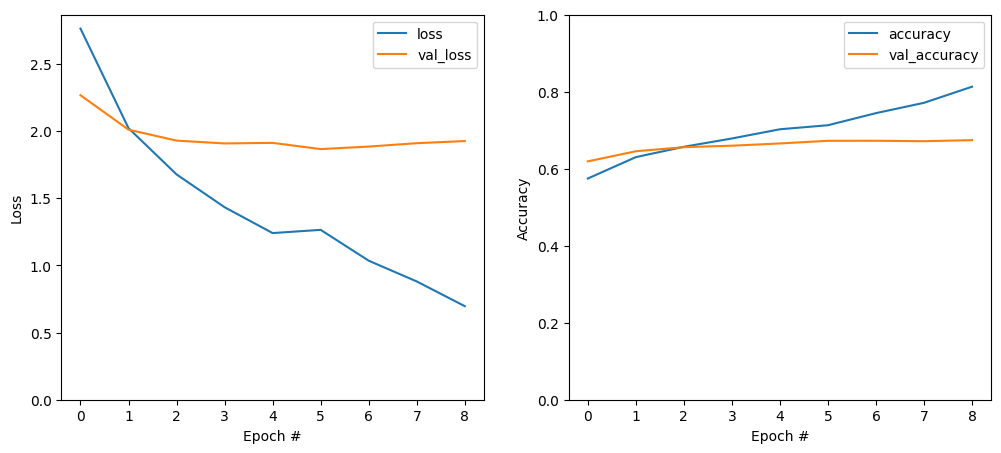

In [100]:

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['masked_acc'], label='accuracy')
plt.plot(history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [101]:

# Save the model
model.save('seq2seq_model_with_pretrained_embeddings.h5')


In [102]:

# Improved prediction function with simplified beam search
def predict(text_en, model=model, max_len=max_len, return_sent=False, pad_sent=False, print_gen=True):
    try:
        if pad_sent:
            sent_id_en = text_en
        else:
            clean_text_en = clean_text(text_en)
            sent_token_en, sent_id_en = tokenize_en([clean_text_en])
            sent_id_en = sent_id_en[0][:max_len] if len(sent_id_en[0]) > max_len else sent_id_en[0] + [0] * (max_len - len(sent_id_en[0]))
        
        sent_id_bn = np.zeros(max_len, dtype=np.int32)
        sent_id_bn[0] = tokenize_bn.word_to_idx[start_token]
        
        # Beam search parameters
        beam_width = 3
        candidates = [(sent_id_bn, 0.0)]  # (sequence, score)
        
        for i in range(max_len - 1):
            all_candidates = []
            
            # Expand each candidate
            for seq, score in candidates:
                if seq[i] == tokenize_bn.word_to_idx[end_token] and i > 0:
                    all_candidates.append((seq, score))
                    continue
                
                test_predict = model.predict(
                    [np.array([sent_id_en]), np.array([seq])], 
                    verbose=0)
                
                # Get top k predictions
                top_preds = np.argsort(test_predict[0][i])[-beam_width:]
                
                # Create new candidates
                for p in top_preds:
                    new_seq = seq.copy()
                    new_seq[i+1] = p
                    new_score = score + np.log(test_predict[0][i][p] + 1e-10)
                    all_candidates.append((new_seq, new_score))
            
            # Select top candidates
            candidates = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
            
            # If all candidates have end token, break
            if all(seq[i+1] == tokenize_bn.word_to_idx[end_token] for seq, _ in candidates):
                break
        
        # Select best candidate
        best_seq, _ = candidates[0]
        
        # Extract result
        result = []
        for j in range(1, max_len):
            if best_seq[j] == tokenize_bn.word_to_idx[end_token] or best_seq[j] == 0:
                break
            result.append(best_seq[j])
        
        if print_gen:
            result_text = ' '.join([tokenize_bn.idx_to_word[i] for i in result])
            print("Bengali (word tokens):", result_text)
        
        if return_sent:
            return best_seq
            
    except Exception as e:
        print(f"Error during prediction: {e}")
        if return_sent:
            return np.zeros(max_len, dtype=np.int32)

# Test some translations
test_sentences = [
    "How are you?",
    "I am fine.",
    "Tomorrow I will go to the market to buy some vegetables."
]

print("\nTesting translations:")
for sentence in test_sentences:
    print(f"English: {sentence}")
    print("Bengali: ", end="")
    predict(sentence, model=model, max_len=max_len)
    print()

# BLEU score implementation
def BLEU(generated_seq, target_seq, weight=[0.25, 0.25, 0.25, 0.25]):
    # Filter out padding and end tokens
    g_seq = [c for c in generated_seq if c > 0 and c != tokenize_bn.word_to_idx[end_token]]
    t_seq = [c for c in target_seq if c > 0 and c != tokenize_bn.word_to_idx[end_token]]
    
    if not g_seq or not t_seq:
        return 0.0
    
    # Convert to words for better interpretability
    g_words = [tokenize_bn.idx_to_word[i] for i in g_seq]
    t_words = [tokenize_bn.idx_to_word[i] for i in t_seq]
    
    # Calculate n-gram precision
    scores = []
    for n in range(1, 5):
        # Skip if sequence is too short
        if len(g_words) < n or len(t_words) < n:
            scores.append(1e-10)
            continue
            
        # Generate n-grams
        g_ngrams = [tuple(g_words[i:i+n]) for i in range(len(g_words)-n+1)]
        t_ngrams = [tuple(t_words[i:i+n]) for i in range(len(t_words)-n+1)]
        
        if not g_ngrams:
            scores.append(1e-10)
            continue
            
        # Count n-grams
        g_counts = Counter(g_ngrams)
        t_counts = Counter(t_ngrams)
        
        # Calculate precision
        matches = sum(min(g_counts[ngram], t_counts.get(ngram, 0)) for ngram in g_counts)
        total = sum(g_counts.values())
        
        scores.append(matches / total if total > 0 else 1e-10)
    
    # Calculate brevity penalty
    bp = min(1, np.exp(1 - len(t_words) / max(len(g_words), 1)))
    
    # Calculate BLEU score
    bleu = bp * np.exp(sum(w * np.log(s) for w, s in zip(weight, scores)))
    
    return bleu

# === BLEU Evaluation on Validation Set ===
val_data = [
    ("How are you?", "তুমি কেমন আছো?"),
    ("I am fine.", "আমি ভালো আছি।"),
    ("Tomorrow I will go to the market to buy some vegetables.", "আগামীকাল আমি বাজারে কিছু সবজি কিনতে যাব।")
]

print("\nCalculating BLEU scores on validation set...")
bleu_scores = []

for en_text, bn_text in val_data:
    print(f"EN: {en_text}")
    print(f"True BN: {bn_text}")
    
    _, target_ids = tokenize_bn([clean_text(bn_text)])
    target_seq = target_ids[0]
    
    generated_seq = predict(en_text, model=model, max_len=max_len, return_sent=True, print_gen=True)
    
    score = BLEU(generated_seq, target_seq)
    bleu_scores.append(score)
    print(f"BLEU: {score:.4f}\n")

avg_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU score over {len(val_data)} samples: {avg_bleu:.4f}")


Testing translations:
English: How are you?
Bengali: Bengali (word tokens): আপনি কেমন আছেন

English: I am fine.
Bengali: Bengali (word tokens): আমি ঠিক গেছি

English: Tomorrow I will go to the market to buy some vegetables.
Bengali: 

Bengali (word tokens): আমি টিকিট ছেড়ে দিতে দিতে হবে


Calculating BLEU scores on validation set...
EN: How are you?
True BN: তুমি কেমন আছো?
Bengali (word tokens): আপনি কেমন আছেন
BLEU: 0.0000

EN: I am fine.
True BN: আমি ভালো আছি।
Bengali (word tokens): আমি ঠিক গেছি
BLEU: 0.0000

EN: Tomorrow I will go to the market to buy some vegetables.
True BN: আগামীকাল আমি বাজারে কিছু সবজি কিনতে যাব।
Bengali (word tokens): আমি টিকিট ছেড়ে দিতে দিতে হবে
BLEU: 0.0000

Average BLEU score over 3 samples: 0.0000


In [104]:
import pickle
model.save('seq2seq_model.keras')
with open('custom_functions.pkl', 'wb') as f:
    pickle.dump({
        'masked_loss': masked_loss,
        'masked_acc': masked_acc
    }, f)
with open('tokenize_en.pkl', 'wb') as f:
    pickle.dump(tokenize_en, f)

with open('tokenize_bn.pkl', 'wb') as f:
    pickle.dump(tokenize_bn, f)
with open('clean_text.pkl', 'wb') as f:
    pickle.dump(clean_text, f)
model_params = {
    'max_length': max_len,
    'embedding_dim': embedding_dim,
    'units': UNITS,
    'en_vocab_size': en_vocab,
    'bn_vocab_size': bn_vocab,
    'start_token': start_token,
    'end_token': end_token,
    'unk_token': unk_token,
    'pad_token': pad_token
}

with open('model_params.pkl', 'wb') as f:
    pickle.dump(model_params, f)
with open('predict_function.pkl', 'wb') as f:
    pickle.dump(predict, f)
translation_environment = {
    'tokenize_en': tokenize_en,
    'tokenize_bn': tokenize_bn,
    'max_len': max_len,
    'clean_text': clean_text,
    'start_token': start_token,
    'end_token': end_token,
    'unk_token': unk_token,
    'pad_token': pad_token,
    'predict_function': predict
}

with open('translation_environment.pkl', 'wb') as f:
    pickle.dump(translation_environment, f)

import pkg_resources
dependencies = {pkg.key: pkg.version for pkg in pkg_resources.working_set}
with open('dependencies.pkl', 'wb') as f:
    pickle.dump(dependencies, f)
model_weights = model.get_weights()
with open('model_weights.pkl', 'wb') as f:
    pickle.dump(model_weights, f)

    # Create a specialized prediction function that carefully handles tensor shapes
def safe_predict(text, model, tokenize_en, tokenize_bn, max_len, clean_text, start_token, end_token):
    """Prediction function with explicit shape and type handling to prevent NotEqual errors"""
    # Clean and tokenize
    clean_text_en = clean_text(text)
    _, sent_id_en = tokenize_en([clean_text_en])
    sent_id_en = sent_id_en[0]
    
    # Pad with explicit type
    sent_id_en_pad = sent_id_en[:max_len] if len(sent_id_en) > max_len else sent_id_en + [0] * (max_len - len(sent_id_en))
    sent_id_en_pad = np.array([sent_id_en_pad], dtype=np.int32)  # Explicit type and batch dimension
    
    # Initialize decoder input with explicit shape and type
    sent_id_bn = np.zeros((1, max_len), dtype=np.int32)
    sent_id_bn[0, 0] = tokenize_bn.word_to_idx[start_token]
    
    # Convert to tensors with explicit types
    sent_id_en_tensor = tf.convert_to_tensor(sent_id_en_pad, dtype=tf.int32)
    sent_id_bn_tensor = tf.convert_to_tensor(sent_id_bn, dtype=tf.int32)
    
    # Generate translation
    for i in range(max_len - 1):
        predictions = model([sent_id_en_tensor, sent_id_bn_tensor], training=False)
        predicted_id = tf.argmax(predictions[0, i], axis=-1).numpy()
        
        if predicted_id == tokenize_bn.word_to_idx[end_token]:
            break
            
        sent_id_bn[0, i+1] = predicted_id
        sent_id_bn_tensor = tf.convert_to_tensor(sent_id_bn, dtype=tf.int32)
    
    # Convert ids to words
    result = []
    for i in range(1, max_len):
        if sent_id_bn[0, i] == 0 or sent_id_bn[0, i] == tokenize_bn.word_to_idx[end_token]:
            break
        result.append(tokenize_bn.idx_to_word[sent_id_bn[0, i]])
    
    return ' '.join(result)

with open('safe_predict.pkl', 'wb') as f:
    pickle.dump(safe_predict, f)